**<h1 align="center">Text Mining</h1>**
**<h2 align="center">Stock Sentiment: Predicting market behavior from tweets</h2>**

**Project Description**
This project focuses on building a sentiment classification model to analyze financial-related tweets and predict the corresponding market sentiment. The classifier labels each tweet into one of three categories:

- **Bearish (0):** Negative outlook on the market or asset  
- **Bullish (1):** Positive outlook on the market or asset  
- **Neutral (2):** Informational or sentiment-neutral content

The pipeline includes text preprocessing, exploratory data analysis, feature engineering using transformer-based embeddings, and training supervised classifiers to optimize performance. Special attention is given to handling class imbalance and tuning the model for generalization on unseen data.

The final goal is to develop a robust NLP model that can infer investor sentiment from textual data, supporting downstream applications such as market forecasting, trading signal generation, or investor behavior analysis.

<a class="anchor" id="chapter1"></a>

# 1. Imports

</a>

In [93]:
#!pip install wordcloud
#!pip install nltk
#!pip install strings
#!pip install transformers
#!pip install torch

In [4]:
# Standard Libraries
import re
import time
import string
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set the style for seaborn
sns.set(style="white")

# Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from tqdm import tqdm
import gensim
from gensim.models import Word2Vec

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Model Evaluation & Splitting
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.utils import resample, class_weight
from sklearn.utils.class_weight import compute_class_weight

# Scikit-learn Models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset

# Transformers & Datasets
from transformers import (
    DistilBertTokenizer,
    DistilBertTokenizerFast,
    DistilBertModel,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
#from datasets import Dataset

In [5]:
# Load the datasets
df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

<a class="anchor" id="chapter2"></a>

# 2. Data Exploration

</a>

- The only values in label are 0,1 and 2
- There are no missing values on both datasets;
- There are no duplicates on both datasets;

In [6]:
# Check the test set
print(df_test.shape)
df_test.head()

(2388, 2)


,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


In [8]:
# Set id as index
df_test.set_index('id', inplace=True)

In [9]:
# Check the train set
print(df_train.shape)
df_train.head()

(9543, 2)


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [10]:
# Check null values
print(f"Null values in labels = {df_train['label'].isna().sum()}")
print(f"Null values in text = {df_train['text'].isna().sum()}")

Null values in labels = 0
Null values in text = 0


In [11]:
# Check for missing values
print("Missing values in train dataset:")
print(df_train.isnull().sum())
print("\nMissing values in test dataset:")
print(df_test.isnull().sum())

Missing values in train dataset:
text     0
label    0
dtype: int64

Missing values in test dataset:
text    0
dtype: int64


In [12]:
# Check for duplicates
print("Duplicates in train dataset:", df_train.duplicated().sum())
print("Duplicates in test dataset:", df_test.duplicated().sum())

Duplicates in train dataset: 0
Duplicates in test dataset: 0


<a class="anchor" id="sub-section-2_1"></a>

## 2.1. Labels

</a>

The average sentiment label in the training dataset is ~1.50, which suggests a **slight tendency toward positive or neutral sentiment**. Since the labels are categorical — Bearish (0), Bullish (1), and Neutral (2) — this average doesn’t map to a real sentiment but indicates that Bearish tweets are less frequent compared to Bullish and Neutral ones

In [13]:
label_counts = df_train['label'].value_counts().sort_index()
label_percent = round(df_train['label'].value_counts(normalize=True) * 100,1)

In [14]:
# get value counts for label
print("Label distribution in train dataset:")
print(label_counts)

# get value counts for label in percentage
print("Label distribution in train dataset (percentage):")
print(label_percent)

Label distribution in train dataset:
label
0    1442
1    1923
2    6178
Name: count, dtype: int64
Label distribution in train dataset (percentage):
label
2    64.7
1    20.2
0    15.1
Name: proportion, dtype: float64


In [15]:
# Check that labels are only 0,1, or 2
df_train['label'].unique()

array([0, 1, 2])

In [16]:
print(f'Unique labels: {df_train["label"].unique()}')
df_train["label"].describe()

Unique labels: [0 1 2]


count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

In [17]:
# Get the label mean
label_mean = df_train['label'].mean()
print(f'Our training set has a mean of {round(label_mean,1)}')

Our training set has a mean of 1.5


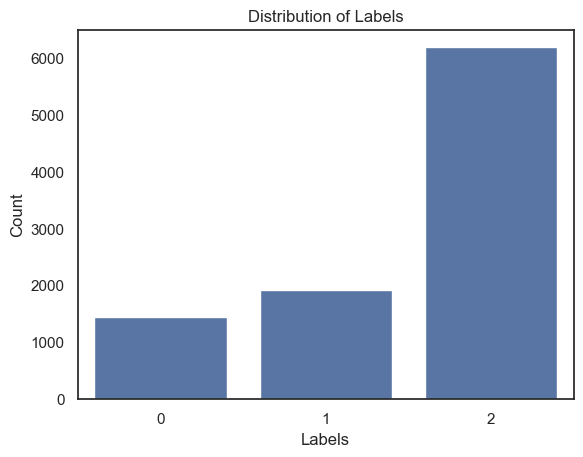

In [18]:
# Visualize distribution of labels
sns.countplot(data=df_train, x='label')
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

<Axes: ylabel='label'>

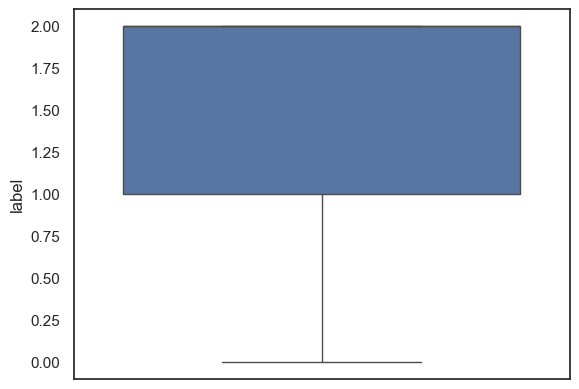

In [19]:
sns.boxplot(data=df_train['label'])

<a class="anchor" id="sub-section-2_2"></a>

## 2.2. Text

</a>

`Key Findings` <br>

The average tweet length in the dataset is approximately 86 characters and 12 words.

Most tweets are fairly short, with 75% under 120 characters and under 15 words.

The shortest tweet has just 2 characters, and the longest reaches 190 characters or 32 words.

This confirms that the dataset fits the typical tweet format and is well-suited for models like RNNs, LSTMs, or Transformers that handle short text.

These findings will also help in setting padding/truncation parameters during preprocessing (e.g., max_len = 32 or max_len = 40 to be safe).

In [ ]:
# Fetch wordcount and character count for each abstract
df_train['word_count'] = df_train['text'].str.split().apply(len)
df_train['char_count'] = df_train['text'].str.len()

df_train[['text','word_count', 'char_count']].head()

,text,word_count,char_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10,77
1,$CCL $RCL - Nomura points to bookings weakness...,14,102
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14,94
3,$ESS: BTIG Research cuts to Neutral https://t....,7,59
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10,71


In [21]:
df_train[['char_count', 'word_count']].describe()

,char_count,word_count
count,9543.000000,9543.000000
mean,85.816934,12.178351
std,35.097229,4.665599
min,2.000000,1.000000
25%,58.000000,9.000000
50%,79.000000,11.000000
75%,120.000000,15.000000
max,190.000000,32.000000


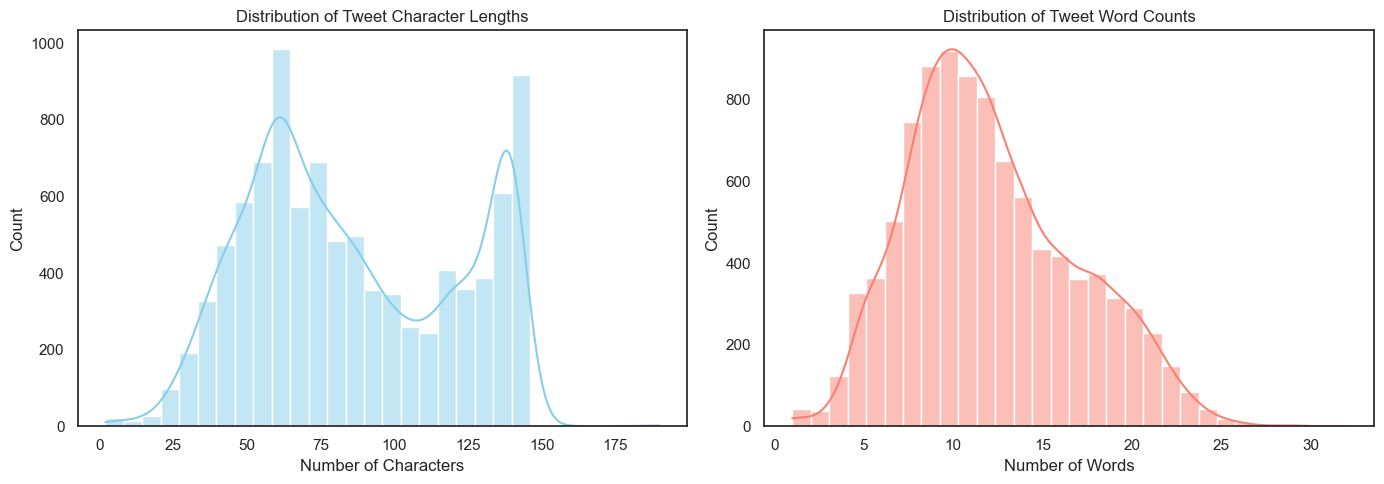

In [22]:
# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character count
sns.histplot(df_train['char_count'], bins=30, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Distribution of Tweet Character Lengths')
axes[0].set_xlabel('Number of Characters')

# Word count
sns.histplot(df_train['word_count'], bins=30, ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Distribution of Tweet Word Counts')
axes[1].set_xlabel('Number of Words')

plt.tight_layout()
plt.show()

In [23]:
all_words = ' '.join(df_train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

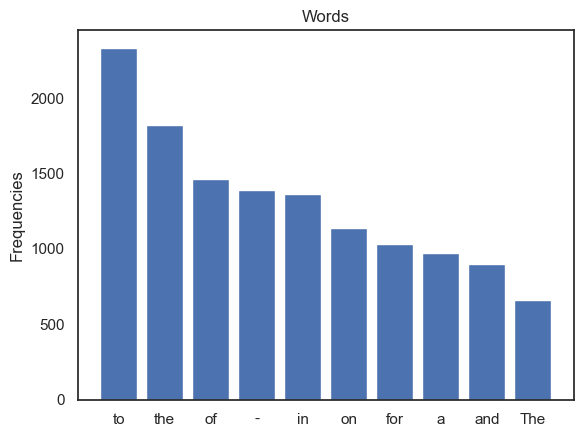

In [24]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=0)
plt.show()

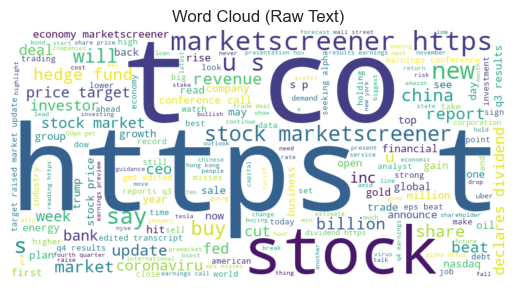

In [25]:
# Create a word cloud from the raw text
raw_text = ' '.join(df_train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

<a class="anchor" id="sub-section-2_3"></a>

## 2.3. Multivariate Analysis

</a>

<a class="anchor" id="sub-section-2_3_1"></a>

### 2.3.1. Word Count & Labels

</a>

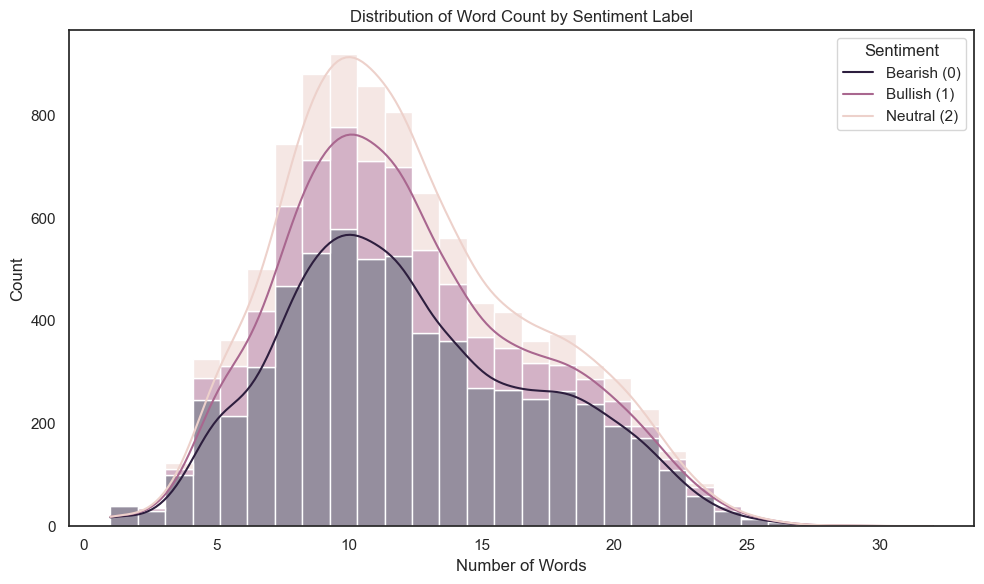

In [26]:
# Histogram of word count by label
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='word_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Word Count by Sentiment Label')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

All three distributions follow a roughly normal shape, suggesting that most tweets have a moderate word count, centered around 10–15 words. The overall count of the Neutral distribution appears higher, suggesting that the Neutral class might be more frequent in the dataset.

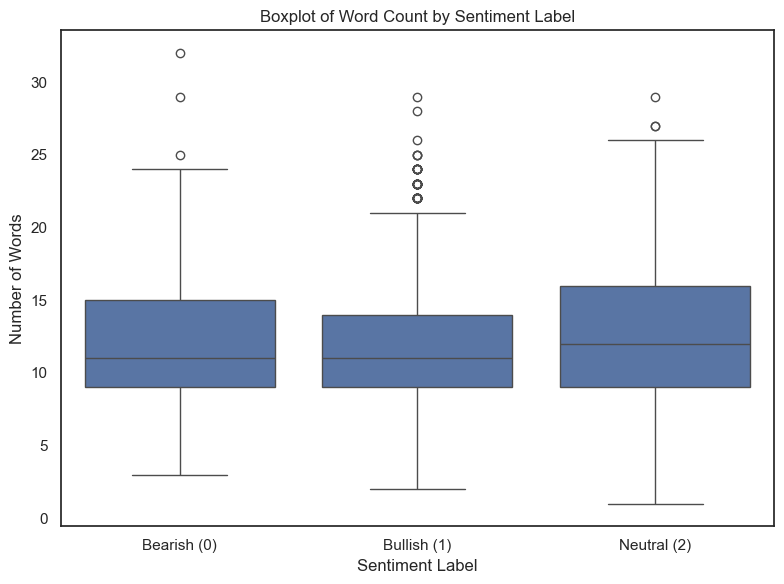

In [27]:
# Boxplot of word count by label
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='word_count')
plt.title('Boxplot of Word Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Words')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

In [28]:
# Get most frequent words
def get_top_n_words(texts, n=20):
    all_words = ' '.join(texts).split()
    most_common = Counter(all_words).most_common(n)
    return dict(most_common)

In [31]:
# Plot word cloud for a specific label
def plot_top_words_bar(df, label, label_name):
    texts = df[df['label'] == label]['text']
    top_words = get_top_n_words(texts)
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(top_words.values()), y=list(top_words.keys()))
    plt.title(f'Top Words for {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.show()

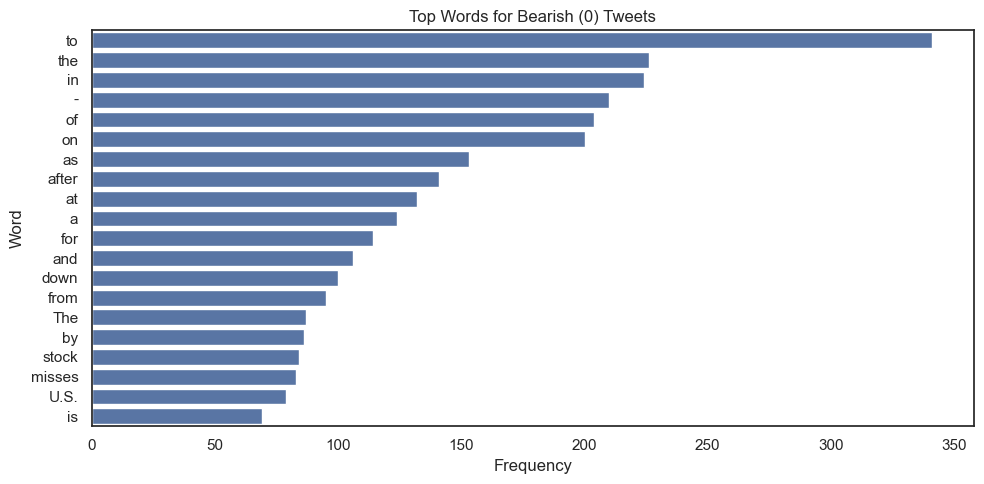

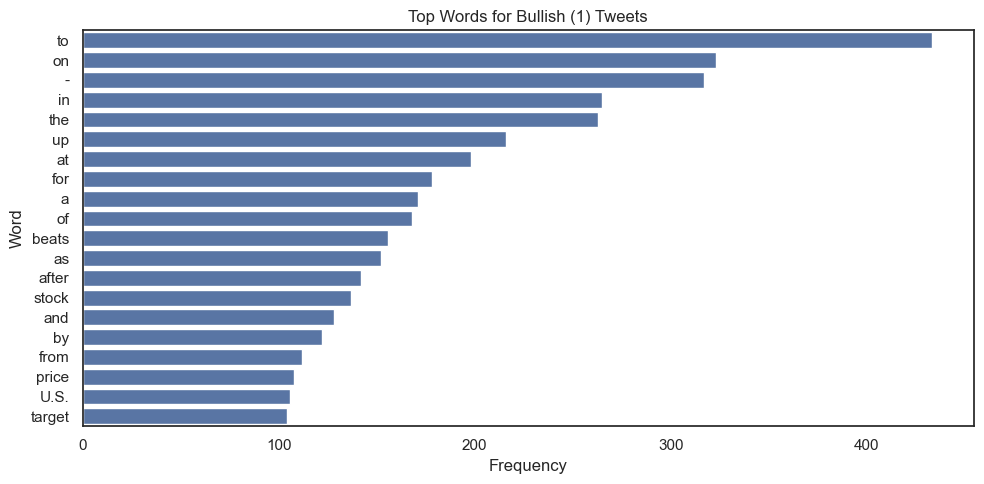

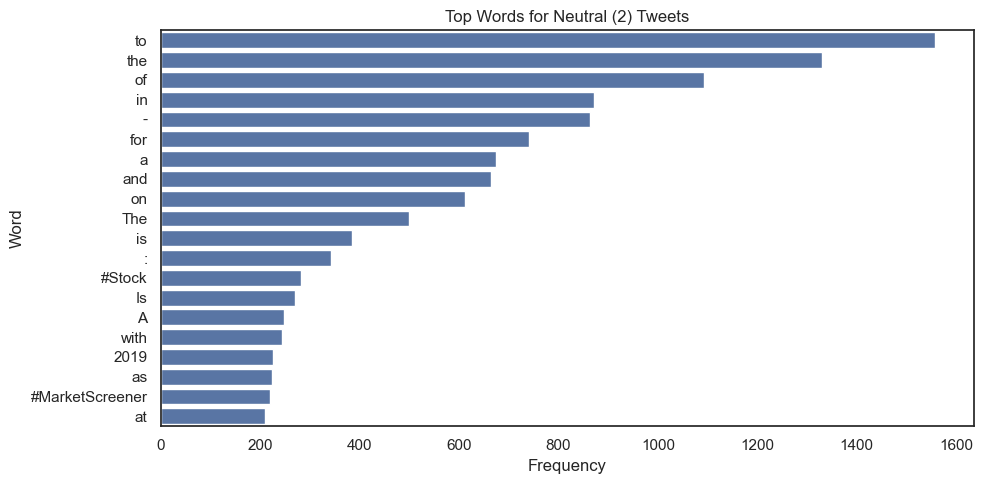

In [32]:
plot_top_words_bar(df_train, 0, 'Bearish (0)')
plot_top_words_bar(df_train, 1, 'Bullish (1)')
plot_top_words_bar(df_train, 2, 'Neutral (2)')

In [33]:
# Plot word cloud for each label
def plot_wordcloud(df, label, label_name):
    texts = df[df['label'] == label]['text']
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {label_name} Tweets', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

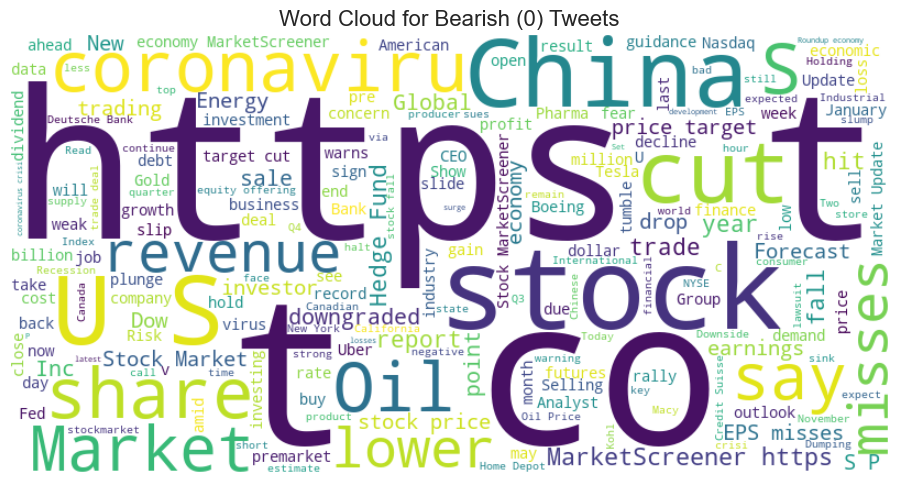

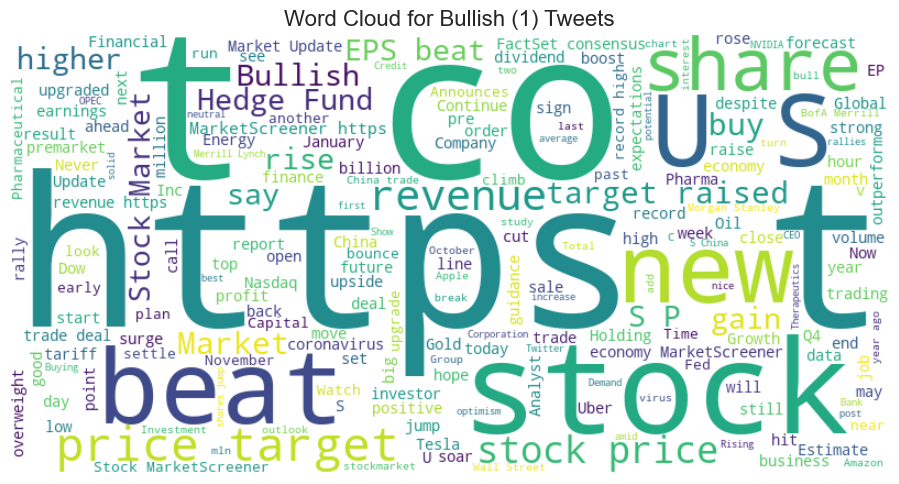

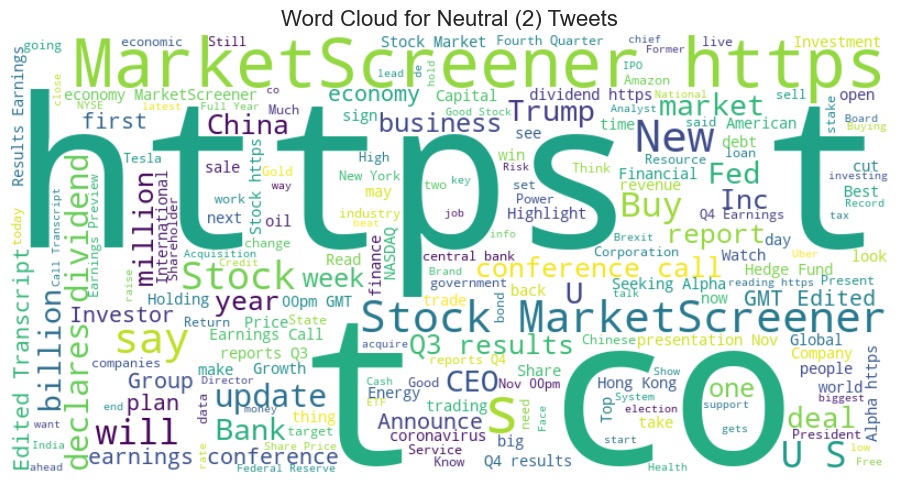

In [34]:
plot_wordcloud(df_train, 0, 'Bearish (0)')
plot_wordcloud(df_train, 1, 'Bullish (1)')
plot_wordcloud(df_train, 2, 'Neutral (2)')

`What the Word Clouds Reveal:` <br>

- Bearish Tweets often contain negatively charged words such as **cut, misses, lower, decline, and crisis-related terms like coronavirus, oil, and China**. This suggests a focus on economic threats, losses, and negative forecasts.

- Bullish Tweets are characterized by positive performance indicators such as **beat, rise, gain, target raised, and higher**. Words like buy and soar indicate strong investor confidence.

- Neutral Tweets tend to include objective and informative language, e.g., **update, conference call, results, CEO, dividend, MarketScreener**. These tweets appear more factual and less emotionally driven.


> The repeated appearance of noise tokens like **https, co, and rt** in all classes confirms the need for text cleaning before model training.

<a class="anchor" id="sub-section-2_3_2"></a>

### 2.3.2. Character Count & Labels

</a>

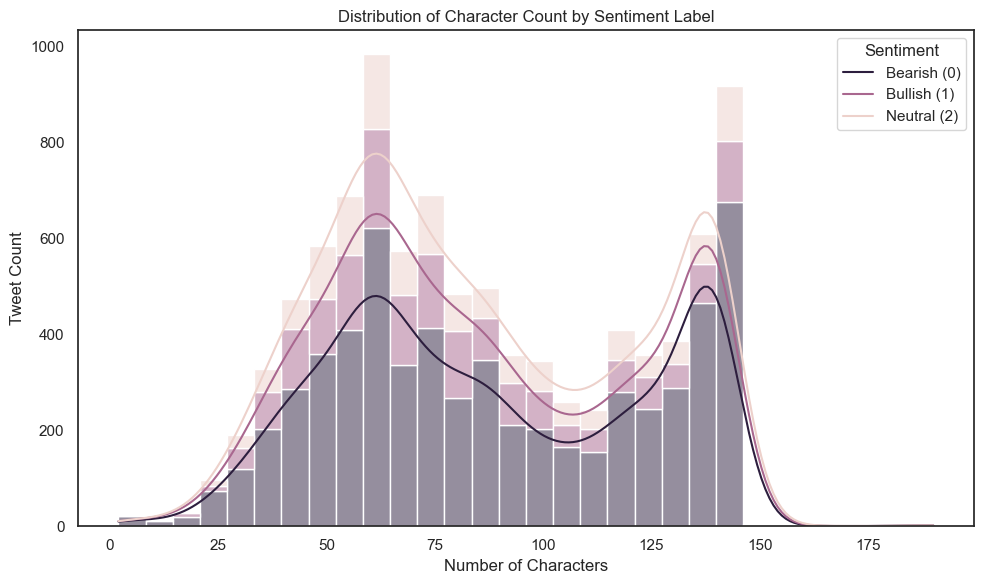

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='char_count', hue='label', kde=True, bins=30, multiple='stack')
plt.title('Distribution of Character Count by Sentiment Label')
plt.xlabel('Number of Characters')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment', labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

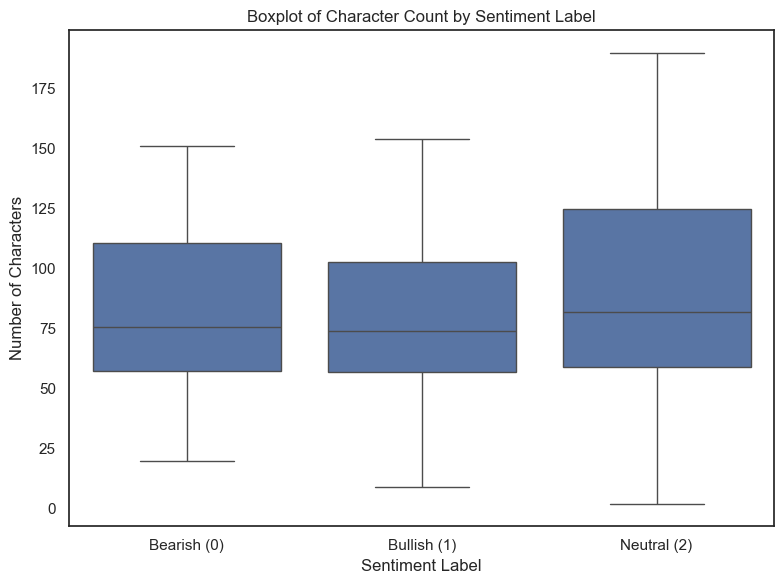

In [36]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_train, x='label', y='char_count')
plt.title('Boxplot of Character Count by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Characters')
plt.xticks(ticks=[0, 1, 2], labels=['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.tight_layout()
plt.show()

<a class="anchor" id="sub-section-2_3_1"></a>

### 2.3.1. N-grams & Labels

</a>

By extracting the most frequent bigrams (2-word sequences) in the dataset, we identify recurring phrase patterns that reflect both the contextual structure of financial tweets and potential informative features for classification.

**A large portion of frequent bigrams are news-source references**, such as:

marketscreener https; <br>
stock marketscreener;<br>
economy marketscreener;<br>
stock https.

These likely come from automatic link-sharing tweets or syndicated content.

**Other bigrams are domain-specific and sentiment-relevant**, such as:

hedge funds;<br>
price target;<br>
stock market;<br>
stock price<br>
q3 results;<br>
earnings conference;

which are informative but likely neutral in tone.

In [37]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df_train['text'])
sum_words = X.sum(axis=0)

# Most common bigrams
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:10]

for word, freq in words_freq:
    print(f"{word}: {freq}")

marketscreener https: 478
stock marketscreener: 315
hedge funds: 163
price target: 141
stock market: 137
economy marketscreener: 137
stock price: 109
q3 results: 99
earnings conference: 90
stock https: 89


In [38]:
# Function to get top n-grams from the corpus
def get_top_ngrams(corpus, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(sorted_words, columns=['ngram', 'count'])

In [39]:
# Function to plot top n-grams
def plot_top_ngrams(df, label, label_name, ngram_range=(2,2), top_n=20):
    texts = df[df['label'] == label]['text'].str.lower()
    top_ngrams = get_top_ngrams(texts, ngram_range=ngram_range, n=top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='ngram', data=top_ngrams)
    title_type = 'Bigrams' if ngram_range == (2,2) else 'Trigrams'
    plt.title(f'Top {title_type} in {label_name} Tweets')
    plt.xlabel('Frequency')
    plt.ylabel(title_type)
    plt.tight_layout()
    plt.show()

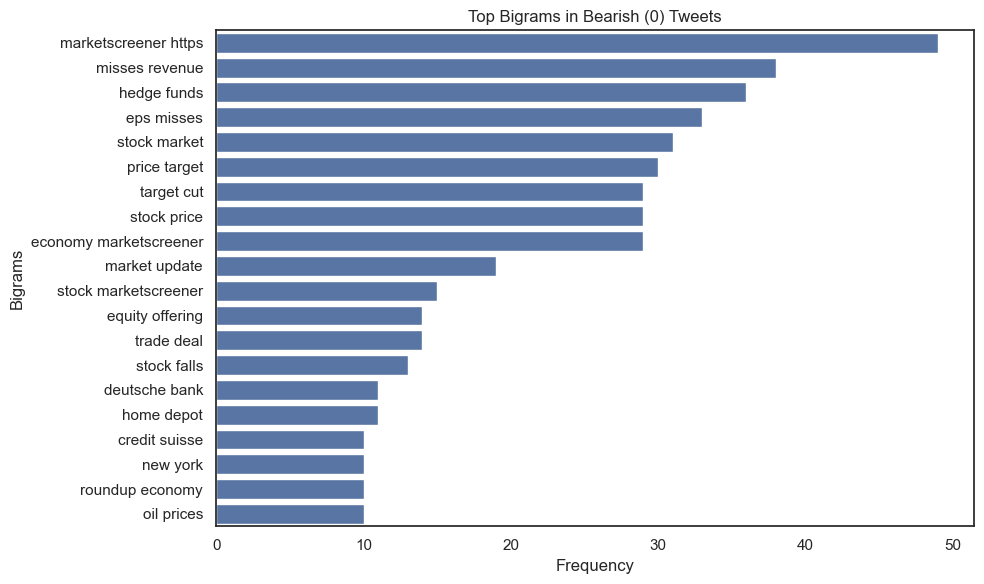

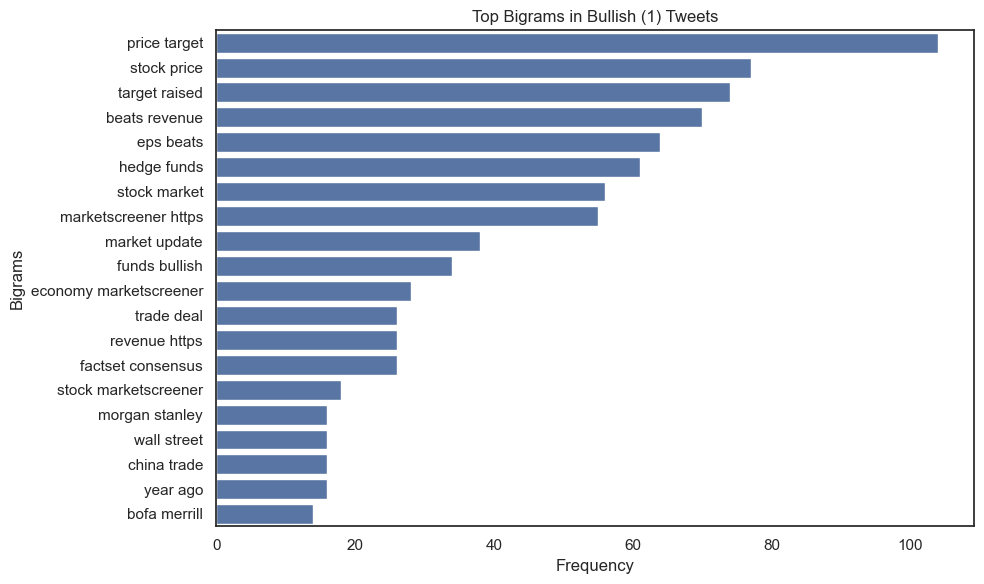

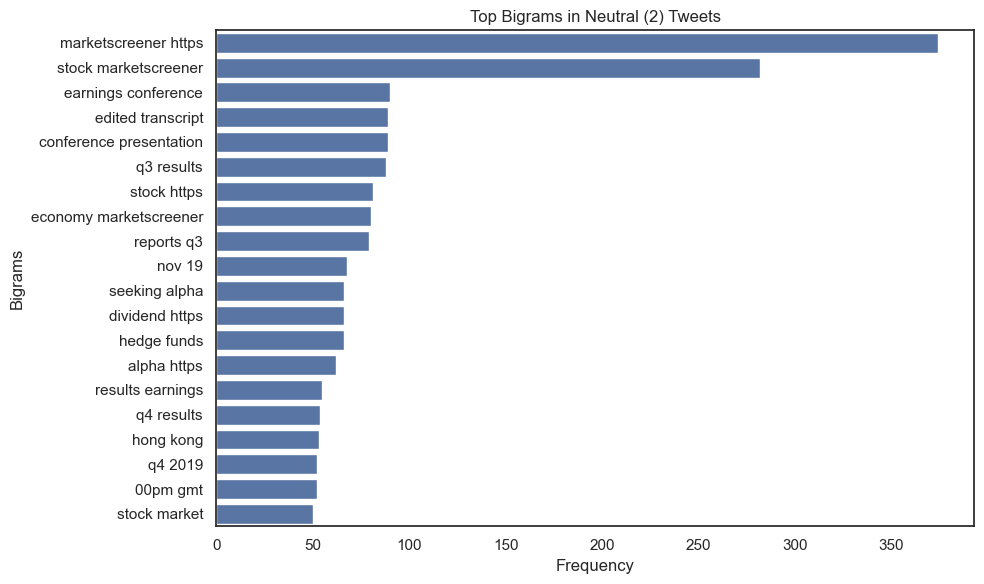

In [40]:
# Bigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(2,2))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(2,2))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(2,2))

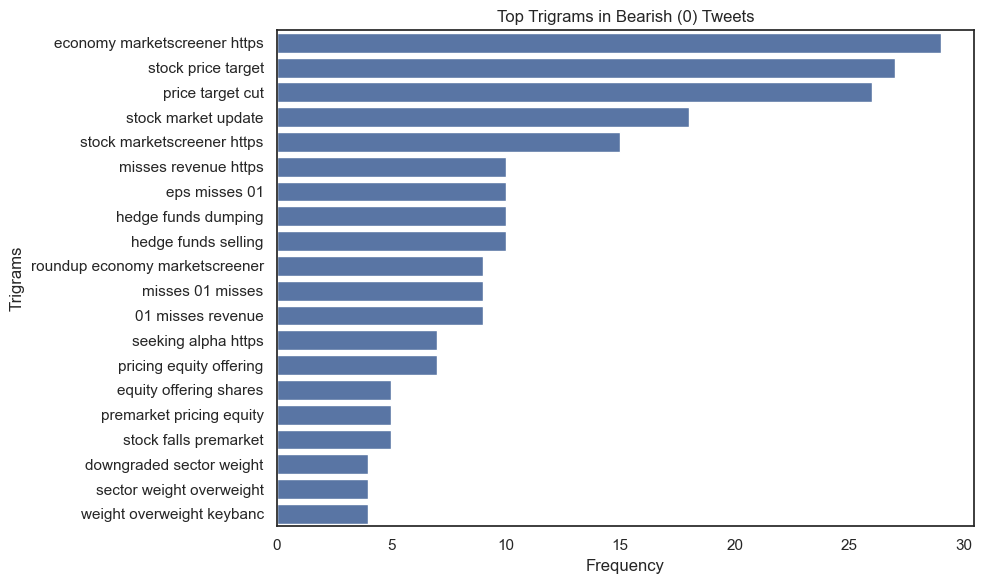

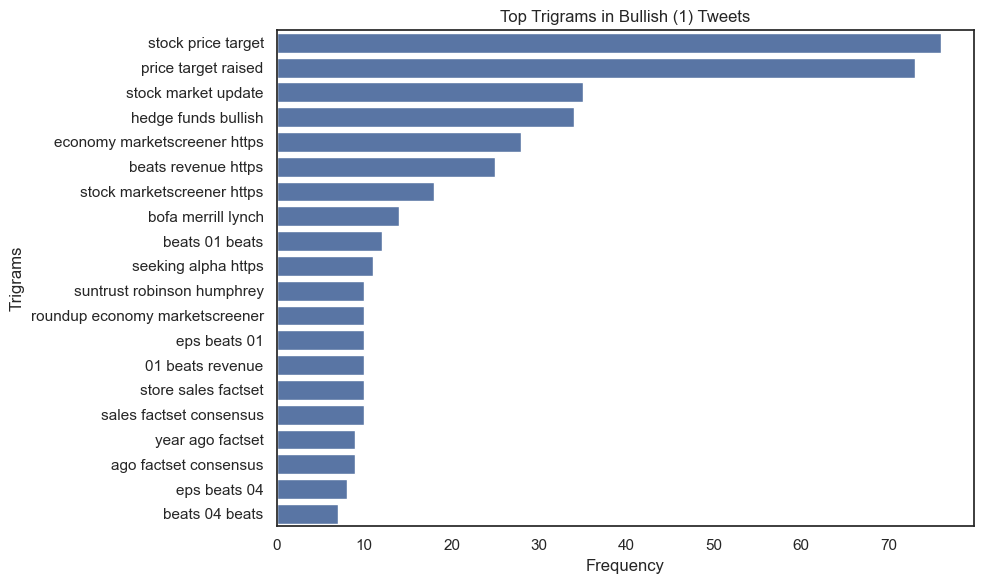

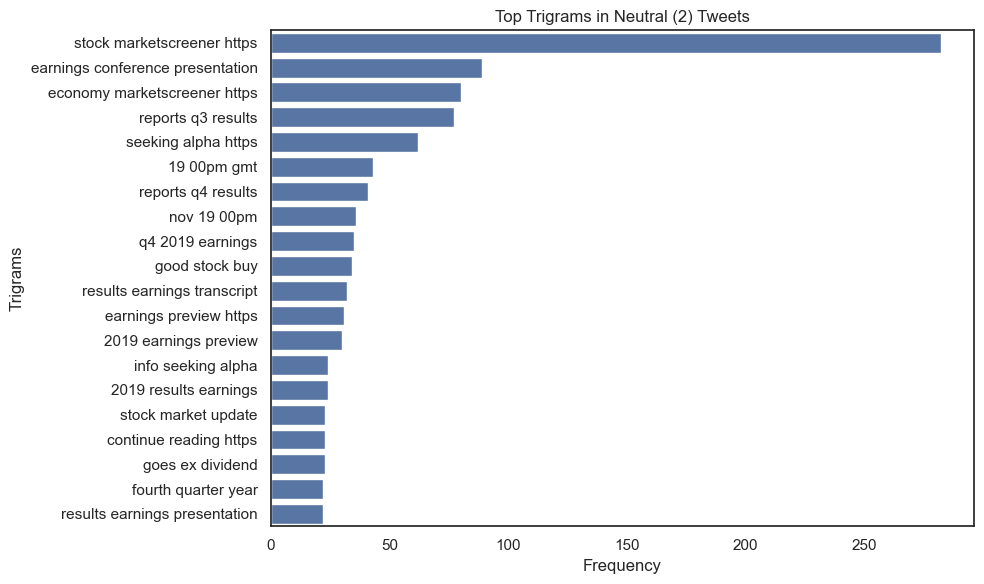

In [41]:
# Trigrams
plot_top_ngrams(df_train, 0, 'Bearish (0)', ngram_range=(3,3))
plot_top_ngrams(df_train, 1, 'Bullish (1)', ngram_range=(3,3))
plot_top_ngrams(df_train, 2, 'Neutral (2)', ngram_range=(3,3))

<a class="anchor" id="chapter3"></a>

# 3. Data Split

</a>

To prepare the dataset for model training and validation, we performed an 80/20 split on the labeled data. This means that **80% of the tweets were used for training, while 20% were held out for validation purposes**. <br>
**The split was done using stratified sampling** to ensure that the distribution of sentiment labels (Bearish, Bullish, and Neutral) remained consistent across both sets. This is **important for preventing class imbalance issues** during training and evaluation. <br>
We did not create a separate test set since a dedicated, unlabeled test dataset was already provided as part of the project. 

In [42]:
train_df, val_df = train_test_split(df_train, test_size=0.2, stratify=df_train['label'], random_state=42)

# Check class distribution
print("Training Set:\n", train_df['label'].value_counts(normalize=True))
print("\nValidation Set:\n", val_df['label'].value_counts(normalize=True))

Training Set:
 label
2    0.647367
1    0.201467
0    0.151166
Name: proportion, dtype: float64

Validation Set:
 label
2    0.647459
1    0.201676
0    0.150864
Name: proportion, dtype: float64


In [43]:
len(train_df), len(val_df)

(7634, 1909)

<a class="anchor" id="chapter4"></a>

# 4. Data Preprocessing

</a>

To prepare the tweets for modeling, we applied a series of text preprocessing steps aligned with the theoretical guidelines from the course. The goal was to clean and normalize the text while retaining meaningful linguistic content for feature extraction.

The following techniques were applied:

`Lowercasing`  All text was converted to lowercase to ensure uniformity (e.g., “Stock” and “stock” are treated the same).

`Noise Removal` We removed URLs, mentions, hashtags, and retweet markers (RT) using regular expressions, as these tokens do not contribute to sentiment analysis.

`Punctuation and Digit Removal` All punctuation symbols and numeric characters were stripped to reduce sparsity and dimensionality.

`Tokenization` We used NLTK’s TreebankWordTokenizer, a rule-based tokenizer that works efficiently without external dependencies like punkt.

`Stopword Removal and Lemmatization` We filtered out common English stopwords (e.g., "and", "the", "of") and lemmatized each remaining token to reduce inflectional variations (e.g., “running” → “run”).

These steps produced a clean and compact representation of the original tweets, ready for downstream tasks like vectorization and sentiment classification.

In [44]:
# Download required resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chloedeschanel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chloedeschanel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chloedeschanel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/chloedeschanel/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [45]:
# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = TreebankWordTokenizer()

In [46]:
# Preprocessing function
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Regex Cleaning
    text = re.sub(r"http\S+|www\S+", '', text)                         # Remove URLs
    text = re.sub(r"@\w+|#\w+|rt", '', text)                           # Remove mentions, hashtags, RT
    text = re.sub(r"br", "", text)                                     # Remove 'br' (e.g. <br> tags)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)      # Remove punctuation
    text = re.sub(r"[^a-zA-Z\s]", ' ', text)                           # Remove numbers and special characters
    text = re.sub(r"\s+", " ", text).strip()                           # Remove extra whitespace

    # 3. Tokenize using Treebank tokenizer
    tokens = tokenizer.tokenize(text)

    # 4. Remove stopwords and short tokens, then lemmatize
    clean_tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]

    return " ".join(clean_tokens)

In [47]:
# Apply function to train and validation datasets
train_df['clean_text'] = train_df['text'].apply(preprocess_text)
val_df['clean_text'] = val_df['text'].apply(preprocess_text)
df_test['clean_text'] = df_test['text'].apply(preprocess_text)

In [48]:
# Check before and after cleaning
print("Original tweet:\n", train_df['text'].iloc[6])
print("Cleaned tweet:\n", train_df['clean_text'].iloc[6])

Original tweet:
 Could Applied DNA Sciences, Inc. (APDN) See a Reversal After Breaking Its 52 Week Low? - The Lamp News
Cleaned tweet:
 could applied dna science inc apdn see reversal eaking week low lamp news


<a class="anchor" id="chapter5"></a>

# 5. Feature Engineering

</a>

In [49]:
X_train_cleaned = train_df['clean_text']
X_val_cleaned = val_df['clean_text']
X_test_cleaned = df_test['clean_text']

<a class="anchor" id="sub-section-5_1"></a>

## 5.1. BoW

</a>

In [50]:
def extract_bow_features(train_texts, val_texts):
    vectorizer = CountVectorizer(binary=True)
    X_train = vectorizer.fit_transform(train_texts)
    X_val = vectorizer.transform(val_texts)
    return X_train, X_val, vectorizer

In [51]:
# Apply BoW to training and validation sets
bow_X_train, bow_X_val, bow_vectorizer = extract_bow_features(X_train_cleaned, X_val_cleaned)

In [52]:
term_counts = np.array(bow_X_train.sum(axis=0)).flatten()
terms = bow_vectorizer.get_feature_names_out()
top_terms_df = pd.DataFrame({'term': terms, 'count': term_counts}).sort_values(by='count', ascending=False)

In [53]:
top_terms_df.head(10)

,term,count
10325,stock,656
6507,market,346
8481,price,315
7244,new,310
9484,say,307
9123,result,304
9735,share,273
3326,earnings,273
5294,inc,246
4345,fund,239


<a class="anchor" id="sub-section-5_2"></a>

## 5.2. TF-IDF

</a>

In [54]:
def extract_tfidf_features(train_texts, val_texts):
    vectorizer = TfidfVectorizer(max_df=0.8, ngram_range=(1,1))
    X_train = vectorizer.fit_transform(train_texts).toarray()
    X_val = vectorizer.transform(val_texts).toarray()
    return X_train, X_val, vectorizer

In [55]:
tfidf_X_train, tfidf_X_val, tfidf_vectorizer = extract_tfidf_features(X_train_cleaned, X_val_cleaned)

In [56]:
# View top 10 IDF values
idf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))
list(idf_dict.items())[4100:4110]

[('firstquaer', 9.247351037092788),
 ('firsttime', 8.554203856532842),
 ('fiscal', 6.721622392784532),
 ('fisher', 9.247351037092788),
 ('fit', 8.841885928984624),
 ('fitbit', 9.247351037092788),
 ('fitful', 9.247351037092788),
 ('fitness', 8.331060305218632),
 ('fittest', 9.247351037092788),
 ('fitzgerald', 9.247351037092788)]

<a class="anchor" id="sub-section-5_3"></a>

## 5.3. Word2Vec

</a>

In [57]:
def get_average_word2vec(texts, model):
    features = []
    for text in texts:
        words = text.split()
        valid_words = [model.wv[word] for word in words if word in model.wv]
        if valid_words:
            avg = np.mean(valid_words, axis=0)
        else:
            avg = np.zeros(model.vector_size)
        features.append(avg)
    return np.array(features)

In [58]:
tokenized_train = [text.split() for text in X_train_cleaned]
tokenized_val = [text.split() for text in X_val_cleaned]

In [59]:
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1)

In [60]:
word2vec_X_train = get_average_word2vec(X_train_cleaned, w2v_model)
word2vec_X_val = get_average_word2vec(X_val_cleaned, w2v_model)

<a class="anchor" id="sub-section-5_4"></a>

## 5.4. Transformer (BERT)

</a>

Here, **we used BERT-based sentence embeddings via the DistilBERT model from Hugging Face**. Unlike traditional methods like TF-IDF, **BERT captures contextual relationships between words, which is particularly useful for short, informal text like tweets**. <br>
We applied DistilBERT’s tokenizer to each tweet, padded and truncated the sequences to a fixed length, and passed them through the pretrained encoder. From the output, we extracted the embedding of the [CLS] token, which serves as a summary representation of the entire tweet. This process produced a 768-dimensional vector for each tweet in both the training and validation sets. <br>
These dense embeddings will be used as input features for our classifier, allowing it to leverage semantic information and improve sentiment prediction performance.

In [54]:
# Load pretrained DistilBERT model and tokenizer
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [55]:
# Convert text to embeddings
def get_bert_embedding(texts, max_len=64):
    embeddings = []

    for text in tqdm(texts):
        inputs = bert_tokenizer(text, return_tensors="pt", max_length=max_len, padding='max_length', truncation=True)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        embeddings.append(cls_embedding)
    
    return torch.tensor(embeddings)

In [56]:
train_embeddings = get_bert_embedding(X_train_cleaned)
val_embeddings = get_bert_embedding(X_val_cleaned)

100%|██████████| 7634/7634 [15:50<00:00, 12.21it/s]

: 

In [ ]:
distilbert_X_train = train_embeddings
distilbert_X_val = val_embeddings

<a class="anchor" id="sub-section-5_5"></a>

## 5.5. Extra method 1

</a>

<a class="anchor" id="sub-section-5_6"></a>

## 5.6. Extra method 2

</a>

<a class="anchor" id="sub-section-5_6"></a>

## 5.7. Chosen Feature Engineering Method

</a>

<a class="anchor" id="chapter6"></a>

# 6. Models

</a>

In [61]:
# Prepare data and get y (labels)
y_train = train_df['label']
y_val = val_df['label']

<a class="anchor" id="sub-section-6_1"></a>

## 6.1. KNN

</a>

In [62]:
# For evaluation
def evaluate_classification(feature_used, y_true, y_pred):
    print("Evaluation metrics with", feature_used, "features.")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision (macro):", precision_score(y_true, y_pred, average='macro'))
    print("Recall (macro):", recall_score(y_true, y_pred, average='macro'))
    print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("\nDetailed Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=4))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

<a class="anchor" id="sub-section-6_1_1"></a>

### 6.1.1. WITH BOW

</a>

In [ ]:

knn.fit(bow_X_train, y_train)
knn_bow_pred = knn.predict(bow_X_val)

In [ ]:
evaluate_classification("BoW", y_val, knn_bow_pred)

Evaluation metrics with BoW features.
Accuracy: 0.7008905185961236
Precision (macro): 0.6831263076597635
Recall (macro): 0.45235912056300404
F1 Score (macro): 0.46991597110124744

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6197    0.1528    0.2451       288
           1     0.7273    0.2286    0.3478       385
           2     0.7024    0.9757    0.8168      1236

    accuracy                         0.7009      1909
   macro avg     0.6831    0.4524    0.4699      1909
weighted avg     0.6949    0.7009    0.6360      1909



<a class="anchor" id="sub-section-6_1_2"></a>

### 6.1.2. WITH TF-IDF

</a>

In [65]:
knn.fit(tfidf_X_train, y_train)
knn_tfidf_pred = knn.predict(tfidf_X_val)

/Applications/anaconda3/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [ ]:
evaluate_classification("TF-IDF", y_val, knn_tfidf_pred)

Evaluation metrics with TF-IDF features.
Accuracy: 0.678365636458879
Precision (macro): 0.6895159168639831
Recall (macro): 0.39828879992714944
F1 Score (macro): 0.3867761852071876

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.5833    0.0729    0.1296       288
           1     0.8095    0.1325    0.2277       385
           2     0.6757    0.9895    0.8030      1236

    accuracy                         0.6784      1909
   macro avg     0.6895    0.3983    0.3868      1909
weighted avg     0.6887    0.6784    0.5854      1909



<a class="anchor" id="sub-section-6_1_3"></a>

### 6.1.3. WITH WORD2VEC

</a>

In [67]:
knn.fit(word2vec_X_train, y_train)
knn_word2vec_pred = knn.predict(word2vec_X_val)

In [ ]:
evaluate_classification("Word2Vec", y_val, knn_word2vec_pred)

Evaluation metrics with Word2Vec features.
Accuracy: 0.607124148768989
Precision (macro): 0.43718162879439976
Recall (macro): 0.4189621597388588
F1 Score (macro): 0.42317495032576363

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.2222    0.1667    0.1905       288
           1     0.3768    0.2779    0.3199       385
           2     0.7126    0.8123    0.7592      1236

    accuracy                         0.6071      1909
   macro avg     0.4372    0.4190    0.4232      1909
weighted avg     0.5709    0.6071    0.5848      1909



<a class="anchor" id="sub-section-6_1_4"></a>

### 6.1.4. WITH DISTIL BERT

</a>

In [ ]:
knn.fit(distilbert_X_train, y_train)
knn_dbert_pred = knn.predict(distilbert_X_val)

In [ ]:
evaluate_classification("Distil BERT", y_val, knn_dbert_pred)

<a class="anchor" id="sub-section-6_2"></a>

## 6.2. Logistic Regression

</a>

In [69]:
clf = LogisticRegression(max_iter=1000, random_state=42)

<a class="anchor" id="sub-section-6_2_1"></a>

### 6.2.1. WITH BOW

</a>

In [70]:
clf.fit(bow_X_train, y_train)
clf_bow_pred = clf.predict(bow_X_val)

In [71]:
evaluate_classification("BoW", y_val, clf_bow_pred)

Evaluation metrics with BoW features.
Accuracy: 0.7888947092718701
Precision (macro): 0.7509790118387301
Recall (macro): 0.6520884994185965
F1 Score (macro): 0.6874656064651626

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.6911    0.4583    0.5511       288
           1     0.7526    0.5610    0.6429       385
           2     0.8092    0.9369    0.8684      1236

    accuracy                         0.7889      1909
   macro avg     0.7510    0.6521    0.6875      1909
weighted avg     0.7800    0.7889    0.7750      1909



<a class="anchor" id="sub-section-6_2_2"></a>

### 6.2.2. WITH TF-IDF

</a>

In [72]:
clf.fit(tfidf_X_train, y_train)
clf_tfidf_pred = clf.predict(tfidf_X_val)

In [73]:
evaluate_classification("BoW", y_val, clf_tfidf_pred)

Evaluation metrics with BoW features.
Accuracy: 0.7684651650078576
Precision (macro): 0.7653564730463723
Recall (macro): 0.5941138149876014
F1 Score (macro): 0.638318134054717

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.7742    0.3333    0.4660       288
           1     0.7510    0.4935    0.5956       385
           2     0.7709    0.9555    0.8533      1236

    accuracy                         0.7685      1909
   macro avg     0.7654    0.5941    0.6383      1909
weighted avg     0.7674    0.7685    0.7429      1909



<a class="anchor" id="sub-section-6_2_3"></a>

### 6.2.3. WITH WORD2VEC

</a>

In [74]:
clf.fit(word2vec_X_train, y_train)
clf_word2vec_pred = clf.predict(word2vec_X_val)

In [75]:
evaluate_classification("BoW", y_val, clf_word2vec_pred)

Evaluation metrics with BoW features.
Accuracy: 0.6516500785751702
Precision (macro): 0.3678979041294874
Recall (macro): 0.3563548102383054
F1 Score (macro): 0.3131705918078143

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       288
           1     0.4430    0.0909    0.1509       385
           2     0.6607    0.9782    0.7886      1236

    accuracy                         0.6517      1909
   macro avg     0.3679    0.3564    0.3132      1909
weighted avg     0.5171    0.6517    0.5410      1909



/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Applicati

<a class="anchor" id="sub-section-6_2_4"></a>

### 6.2.4. WITH DISTIL BERT

</a>

In [ ]:
clf.fit(distilbert_X_train, y_train)
clf_dbert_pred = clf.predict(distilbert_X_val)

In [ ]:
print("Validation Set Results:\n")
print(classification_report(y_val, clf_dbert_pred, target_names=["Bearish", "Bullish", "Neutral"]))

<a class="anchor" id="sub-section-6_3"></a>

## 6.3. Basic Multi-Layer Perceptron (MLP)

</a>

We trained a Multi-Layer Perceptron (MLP) using the BERT-based embeddings from the training set and evaluated its performance on the validation set. With a maximum of 1000 iterations and early stopping enabled, the model converged after 27 epochs and achieved an overall accuracy of 74%. It maintained strong performance on Neutral tweets (F1-score of 0.84), while Bearish and Bullish classes remained more challenging, with F1-scores of 0.44 and 0.53 respectively. These results indicate that the MLP captured some non-linear patterns in the data, but performance on the minority classes was still limited, likely due to class imbalance and overlapping sentiment cues. Further improvements may require rebalancing the training data or switching to a more flexible modeling framework like PyTorch.

In [ ]:
# Initialize MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    max_iter=1000,          
    random_state=42,
    early_stopping=True,
    verbose=True
)

<a class="anchor" id="sub-section-6_3_4"></a>

### 6.3.4. WITH DISTIL BERT

</a>

In [ ]:
# Train on training set
mlp.fit(distilbert_X_train, y_train)

In [ ]:
val_preds = mlp.predict(distilbert_X_val)
print("Validation Set Results:\n")
print(classification_report(y_val, val_preds, target_names=["Bearish", "Bullish", "Neutral"]))